# Analyzing Overwatch Forum Posts

This is an analysis of data I scraped from Blizzard's official Overwatch general discussion <a href="https://us.battle.net/forums/en/overwatch/22813879/">forum</a>. For more information on how scraping was performed or about this project in general, visit my repo <a href="https://github.com/dskarbrevik/W266_Project_Skarbrevik">here</a>.

<a id="toc"></a>

## Table of Contents
<ol>
    <li>[Setting up the environment](#section1)</li>
    <br>
    <li>[Preprocessing the data](#section2)</li>
    <br>
    <li>[Exploratory Data Analysis on whole dataset](#section3)</li>
    <br>
    <li>[Creating language models by month](#section4)</li>
    <br>
    <li>[Analyzing user life cycle](#section5)</li>
</ol>

***

<a id='section1'></a>

## 1) Setting up the environment



#### Import libraries

In [5]:
import pandas as pd
import numpy as np
import utils # utils.py can be found in repo; contains helper functions used in this notebook
import nltk
import re
import sys
import string
import random
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
# if you don't have nltk data downloaded, 
# you will need to do that before being able to execute the later parts of this notebook.
# Use the below command to do so:

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [69]:
# in case I need to reload utils after editing it...

import importlib
importlib.reload(utils)

<module 'utils' from 'C:\\Users\\skarb\\Documents\\GitHub\\Forum-User-Lifecycle-Analysis\\utils.py'>

Note: nltk data must be downloaded prior to running cells further in this notebook. Run `nltk.download()` to install necessary data.

**Import full dataset!! yaaay**

In [6]:
master_db = pd.read_csv("C:\\Users\\skarb\\Desktop\\overwatch_database.csv", encoding="ISO-8859-1")

***

<div align="right">
    [back to top](#toc)
</div>

<a id='section2'></a>

## 2) Preprocessing the data

#### a) Remove duplicate posts: both exact duplicates and situations where a user just reposted the exact same topic text and post text

Only after much anguish while troubleshooting the creation of my language models... I realized for some strange reason there are duplicate rows in this dataset. It's probably something you should always check for right away, but in my mind it seemed pretty silly to think that the Blizzard forum would have the exact same post displayed twice on their website... anyway now it's the first step in this notebook... 

[UPDATE!]

After thinking I had solved my issue, it turns out that while the vanilla "drop_duplicates()" Pandas function did get rid of all exact copies of posts in the dataset, it didn't get rid of rows where just the "user" and "text" were identical. After debating whether these rows should be removed, I have decided to remove them as such posts are not in line with the idea of tracking changes in the user over time.

[UPDATE... again]

I have a function that creates a unified "all_text" column in the dataframe that is simply "topic" + " " + "text" OR if "topic" doesn't end in punctuation "topic" + ". " + "text" (I add a period to separate the topic and text). Ultimately there isn't much reason for me to do it, but it revealed to me that some forum users made a post where the topic ended without punctuation and then made a new post that's exactly the same except now the topic has a "." at the end... I'm choosing to label these as duplicate posts as well and delete them but it makes me question how many other "soft duplicates" (just made that up) exist in the dataset. Intuitively there probably aren't that many since other users and moderators would certainly discourage such behavior from a given user. Also, the case I described about a user posting once without punctuation and again with punctuation occured only 16 times in over 400,000 posts, so again probably not a huge deal, but an interesting problem to consider.

**... tl;dr this step is very important!**

In [7]:
before_size = master_db.shape[0]
master_db = master_db.drop_duplicates(subset=["topic","text","user"])
after_size = master_db.shape[0]

print("You dropped {} duplicate rows.".format(before_size - after_size))

You dropped 125703 duplicate rows.


#### b) Remove any rows with more than 1 NaN value
Setting "thresh" the way I do here allows 1 NaN per row of table. This way we can allow forum posts where the user entered a topic line but no body text (as this may still be valuable data).

In [8]:
master_db = master_db.dropna(thresh=len(master_db.columns.tolist())-1)

#### c) Remove users that are "community managers" (i.e. employees)

This will remove all forum posts from users that are employees of Blizzard. Because these posts are not representative of the thoughts/motivation/language of a non-affiliated forum user, I believe removing these posts is a necessary step. I formed the list of employee users by hand so it is possible that it is not complete, but to the best of my knowledge it is. Ultimately, this removes a very small number of rows from the dataset, so not likely consequential either way.

In [9]:
admin_list = ["Lylirra", "Tom Powers", "Josh Engen", "Jeff Kaplan", "Scott Mercer", "Michael Chu", "Geoff Goodman", "Zoevia"]

admins_in_df = utils.check_for_admins(master_db, "user", admin_list)

master_db = utils.remove_admins(master_db, "user", admins_in_df)

There were admins in the dataframe.
Found 8 admins in the dataframe. Removing those users dropped 1316 rows from the dataframe.


#### d) Convert 'date' and 'time' columns to datetime objects and combine them

(This could take a minute)

In [10]:
master_db['date'] = pd.to_datetime(master_db['date'])
master_db['time'] = pd.to_timedelta(master_db['time'] + ':00', unit='h')

In [11]:
master_db['date'] = master_db['date'].add(master_db['time']) # combine features into one date/time feature
master_db = master_db.drop(['time'], axis=1)

#### e) Sort dataframe by date

In [12]:
master_db = master_db.sort_values(by='date')
master_db = master_db.reset_index(drop=True)

###  [DON'T DO STEPS f or g]
This was used when the only text I had were from OP, but now that I have all replies as well, most rows in this database don't have a "topic"... it's already combined.

#### f) Combine "topic" and "text" features

(This could take a minute)

To create one unified chunk of text for each post without sacrificing data, I am going to make a new feature in the dataframe that treats the "topic" of a post as the first sentence of a post. From my experience of the significance of topic lines in posts of this forum, this seems like a reasonable assumption.

In [12]:
# DON'T DO THIS
#master_db = utils.combine_text_cols(master_db)

#### g) Another row drop for "soft duplicates" (read blurb above in section 2a. for more info)

In [13]:
# DON'T DO THIS
# before_size = master_db.shape[0]
# master_db = master_db.drop_duplicates(subset=["user", "all_text"])
# after_size = master_db.shape[0]

# print("You dropped {} duplicate rows.".format(before_size - after_size))

You dropped 16 duplicate rows.


#### h) Rearrange columns for better viewing

In [13]:
master_db.columns.tolist()

['date',
 'downvotes',
 'op?',
 'text',
 'topic',
 'topic_id',
 'upvotes',
 'user',
 'user_posts']

In [14]:
old_cols = master_db.columns.tolist()
new_cols = ['topic_id','date', 'user', 'op?','topic','text', 'upvotes', 'downvotes' 'user_posts']

if set(old_cols) == set(new_cols):
    master_db = master_db[new_cols]


### What the data looks like AFTER pre-processing:

In [16]:
master_db.head()

,date,downvotes,op?,text,topic,topic_id,upvotes,user,user_posts
0,2016-05-23 11:34:00,5,True,A new topic?,Could this be...,20744126275,0,Ralavik,2274 posts
1,2016-05-23 11:37:00,9,True,I'm curious what kind of exodus Battleborn wil...,Who else dropped Battleborn like a brick,20744265647,26,d3fqon,307 posts
2,2016-05-23 11:38:00,0,True,Want to find a decent team to hang out and put...,Looking for skilled players,20744155750,0,Bammer,59 posts
3,2016-05-23 11:40:00,2,True,Best Monday of the year,Game is live...,20744185537,7,Omni,7 posts
4,2016-05-23 11:41:00,1,True,Apparently all of us were supposed to receive ...,Free Battletag Change?,20744275856,1,LilaSawyer,662 posts


In [17]:
master_db.shape

(5377317, 9)

In [56]:
master_db[master_db.user=="KiwiRider"]

,date,downvotes,op?,text,topic,topic_id,upvotes,user,user_posts
4384000,2017-10-18 08:38:00,0,False,Does anyone know if Blizzard punishes this beh...,QP Needs Re-work..,20759209346,0,KiwiRider,4 posts


In [50]:
for text in mitch['text'].tolist():
    print(text)
    print("\n")

So when should we expect a new Hanzo skin? Like next year?


04/11/2017 11:24 AMPosted by RusemanWhat does Hanzo has to do with this event? I can't believe you expected him to be on it.When did I say I expected him to get a skin from this event? I am just wondering when he will get a skin. Nice assumption though!




**Note on final features:** Some features (i.e. "num_replies" and "time_last_reply") will not be used in subsequent analysis and modeling. However, these features are included because they may be useful for future work.

***

## !! UNDER CONSTRUCTION !!

** [Ideas for more analysis] **

* some visual analysis...
    * histogram of number of words per post
    * histogram of number of posts per user [DONE]

<div align="right">
    [back to top](#toc)
</div>


<a id='section3'></a>

## 3) Exploratory Data Analysis on whole dataset

In [16]:
total_posts = master_db.shape[0]
total_users = len(set(master_db['user']))
avg_post = total_posts/total_users
#freqdist = utils.count_tokens(master_db["all_text"].tolist())
print("Size of dataset = {0:.2f} MB".format(sys.getsizeof(master_db)/1000000))
print("Number of forum posts = {}".format(total_posts))
print("Number of posts dropped due to NaN or duplicate: {}".format(before_size-master_db.shape[0]))
print("Feature names: {}".format(list(master_db)))
print("Most replies a post received: {}".format(max(master_db['num_replies'])))
print("Average number of replies per post: {0:.2f}".format(np.mean(master_db['num_replies'])))
print("Number of unique users: {}".format(len(set(master_db['user']))))
print("Number of users with over 50 posts: {}".format(len(utils.users_with_n_posts(master_db, 50))))
print("Average number of posts per user: {0:.2f}".format(avg_post))
print("Oldest Post in Dataset: {}".format(master_db['date'].tolist()[0]))
print("Newest Post in Dataset: {}".format(master_db['date'].tolist()[-1]))
#print("Some of the most common words/tokens in the dataset:")
#freqdist.most_common(50)

Size of dataset = 638.55 MB
Number of forum posts = 426047
Number of posts dropped due to NaN or duplicate: 16
Feature names: ['date', 'user', 'all_text', 'topic', 'text', 'num_replies', 'time_last_reply']
Most replies a post received: 8749
Average number of replies per post: 9.97
Number of unique users: 85308
Number of users with over 50 posts: 1364
Average number of posts per user: 4.99
Oldest Post in Dataset: 2016-05-23 23:34:00
Newest Post in Dataset: 2017-11-18 04:53:00


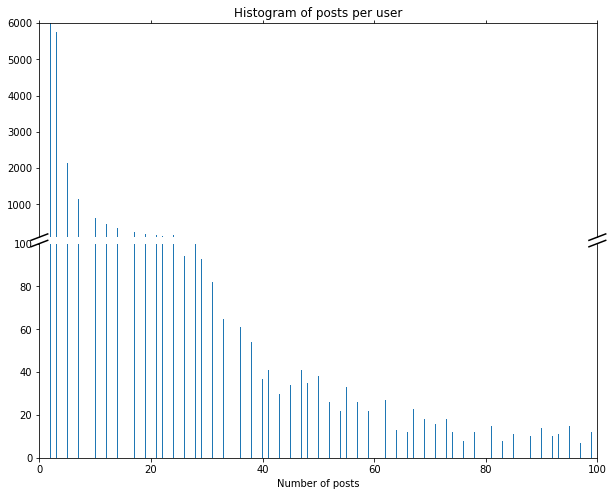

In [33]:
utils.plot_user_posts(master_db)

Note how the scale changes on the y axis. So, we can see that posts are HEAVILY skewed toward users that have made very few posts. Further, this dataset does not include any users that made 0 posts of their own, but may have written many replies to posts. Intuitively, and as the EDA above shows, there are likely many such users.

**Note on quantity of data:** This dataset does not look at the text in replies to forum post, it only looks at the forum post text itself. However because we see an average of about 10 replies per post, if we assume that the replies to a post have about as much text each as the post itself (actually seems possible for this forum) then gathering this data would increase our dataset by an order of magnitude. Something to keep in mind if "needing more data" seems like a problem down the line.

***

<div align="right">
    [back to top](#toc)
</div>

<a id="section4"></a>

## 4) Creating language models by month

Because dates range from 2016-05-23 to 2017-11-18 we will be able to make 17 "per month slices" starting with June 2016 and ending with October 2017.

Let's create separate dataframes for each FULL month of posts. This includes the timespan of 06/2016 to 10/2017. A total of 17 months. Just short of a year and a half! Compared to the RateBeer/BeerReview datasets (around 10 years) this will be a very small time frame. However the density of posts in this short time is very high so we're hopeful that something may come of this :)

#### a) Creating monthly slices from the dataset

First get all months with posts and create labels to make variable naming easier later on...

In [57]:
month_labels = utils.get_month_labels(master_db)
month_labels

defaultdict(<function utils.get_month_labels.<locals>.<lambda>>,
            {2016: ['05_2016',
              '06_2016',
              '07_2016',
              '08_2016',
              '09_2016',
              '10_2016',
              '11_2016',
              '12_2016'],
             2017: ['01_2017',
              '02_2017',
              '03_2017',
              '04_2017',
              '05_2017',
              '06_2017',
              '07_2017',
              '08_2017',
              '09_2017',
              '10_2017',
              '11_2017',
              '12_2017'],
             2018: ['01_2018', '02_2018']})

Now let's use our list of labels to slice our dataset...

In [58]:
df_by_month = utils.make_all_months(master_db, month_labels)

With all the months separated, let's see how many posts are in each month:

In [59]:
utils.eda_on_months(df_by_month)

Average number of posts each month: 244423.50
Fewest posts: df_05_2016 with 51876 posts
Most posts: df_03_2017 with 332565 posts




We see that one month has an incredibly small amount of posts but this is to be expected because 05/2016 is the first month of the forum's existence and the forum did not start on 5/1/2016. Although 11/2017 has about as many posts as any other month in our dataset, we will also remove this month because it does not include posts for the full month (scraped on 11/18/2017).

In [60]:
# removing the beginning and most current month of the forum to avoid incomplete months
df_by_month.pop('df_05_2016')
df_by_month.pop('df_02_2018')

,date,downvotes,op?,text,topic,topic_id,upvotes,user,user_posts
5248773,2018-02-01 01:00:00,5,True,I reported 4 people last week: one person for ...,Report feature is actually working.,20761706073,9,Fiotality,1140 posts
5248774,2018-02-01 01:00:00,0,False,the link won't work for me what happend plz te...,Making fun of Mercy Mains Now,20761665966,1,Crashplayz,116 posts
5248775,2018-02-01 01:00:00,0,False,Bump....anyone :-),Replace Hanzo Scatter NEW ABILITY,20761027778,0,Acrobatlip,3 posts
5248776,2018-02-01 01:00:00,0,False,02/01/2018 04:57 AMPosted by Kusanagi1Why do p...,Mercy lowest picked healer,20761606078,8,Selling,91 posts
5248777,2018-02-01 01:00:00,1,False,It was actual cringe lmao how much did they pa...,"""Play nice, Play Fair"" Yeah right",20761636010,22,Darkxsamurai,1322 posts
5248778,2018-02-01 01:00:00,1,False,01/31/2018 04:52 PMPosted by telepekI'm... I'm...,"""Play nice, Play Fair"" Yeah right",20761636010,23,creek,915 posts
5248779,2018-02-01 01:00:00,1,False,There is nothing compelling to mercy's game pl...,"[Feedback Thread] Mercy Updates - Jan 30, 2018",20761088072,11,LunaPearl,6 posts
5248780,2018-02-01 01:00:00,1,False,Are you trying to reason with angry people tha...,#MercyIsStillOP,20761646020,0,Sengell,982 posts
5248781,2018-02-01 01:00:00,1,False,01/31/2018 04:53 PMPosted by dradventure01/31/...,Reaper doesn't need a spread reduction they sa...,20761636018,2,Katuchi,806 posts
5248782,2018-02-01 01:00:00,0,True,Lets be chill and share some of our favorite ...,Yo do you feel the beat?,20761606026,0,dradventure,1163 posts


With the ends trimmed we are confident that every dataframe in our `df_by_month` contains a full month of posts.

#### b) creating language models for each month

All language models will be trigrams for now. Scoring ultimately will use add-k smoothing, but I will improve this in the future with some form of back-off smoothing.

We will save a version of the snapshot model that does not have any of the users that were used in making the trigram language model. This version will be used to subsequently analyze the language model. 

**[Note to myself]**
It may be a bit harsh to remove all of a user's posts instead of just the posts that were used to make the training data... I should try it both ways and think more about it.

**[Another note to myself]** .. OK I thought about it and decided it's too harsh to throw out a user from analysis just because some of their posts are in the training data, because A) I'm still removing the posts that user contributed to training the LMs and B) I'm only letting a user contribute 2 posts to any given LM (0.2% of training data).

(This could take a minute)

In [64]:
df_no_train, trigram_counts, trigram_context_totals = utils.trigram_models_by_month(df_by_month)

Model for df_06_2016 built successfully
Model for df_07_2016 built successfully
Model for df_08_2016 built successfully
Model for df_09_2016 built successfully
Model for df_10_2016 built successfully
Model for df_11_2016 built successfully
Model for df_12_2016 built successfully
Model for df_01_2017 built successfully
Model for df_02_2017 built successfully
Model for df_03_2017 built successfully
Model for df_04_2017 built successfully
Model for df_05_2017 built successfully
Model for df_06_2017 built successfully
Model for df_07_2017 built successfully
Model for df_08_2017 built successfully
Model for df_09_2017 built successfully
Model for df_10_2017 built successfully
Model for df_11_2017 built successfully
Model for df_12_2017 built successfully
Model for df_01_2018 built successfully
DONE BUILDING MODELS


#### c) Testing out our new language models (generating sentences for fun)

In [65]:
for key in df_by_month.keys():
    print("Snapshot model from {}/{}".format(key[3:5], key[6:]))
    print("Fake/generated sentence:")
    utils.print_fake_sentences(trigram_counts[key], trigram_context_totals[key], n=1)

Snapshot model from 06/2016
Fake/generated sentence:
Soldier:76 McCree ruin Pharah 's day
cross-entropy = 46.17


Snapshot model from 07/2016
Fake/generated sentence:
If anything 've made Zenyatta even unplayable
cross-entropy = 57.64


Snapshot model from 08/2016
Fake/generated sentence:
Only one option Git gud
cross-entropy = 34.58


Snapshot model from 09/2016
Fake/generated sentence:
Not much mute report move on.As started I n't feel ready
cross-entropy = 102.34


Snapshot model from 10/2016
Fake/generated sentence:
But agreed 're bit putting.I like new coloring armor
cross-entropy = 80.57


Snapshot model from 11/2016
Fake/generated sentence:
11/17/2016 09:10 PMPosted BonesIt 's going changes internally feels solid etc
cross-entropy = 103.50


Snapshot model from 12/2016
Fake/generated sentence:
Judging topic evidently
cross-entropy = 11.52


Snapshot model from 01/2017
Fake/generated sentence:
You give lil kids least one leaver whether side enemy 's
cross-entropy = 103.43


Snaps

The sentences don't make a ton of sense, but they're only using add-k smoothing and the language models have nltk.stop_words filtered out so the language would be somewhat "caveman" like.

Also, notice that as a sentence becomes longer it naturally has higher cross-entropy. This is a problem with measuring cross-entropy in language models and is why I limited posts to a maximum of 30 words when building language models.

***

<div align="right">
    [back to top](#toc)
</div>

<a id="section5"></a>

## 5) Analyzing user life cycle


#### a) find some candidate users to analyze

In [66]:
user_count = Counter()
for key in list(df_no_train.keys()):
    user_list = Counter(list(set(df_no_train[key]['user'].tolist())))
    user_count += user_list
    
users = user_count.most_common(5)
print(users)
active_user_list = []
for user in users:
    active_user_list.append(user[0])

[('Bastion', 20), ('Cosmic', 20), ('Mel', 20), ('Raven', 20), ('Rezbit', 20)]


Any users we see above with the value '17' have posted at least once every month from 06/2016 - 10/2017. We'll dive into 5 of the most active users (users that posted consistently).

In [67]:
for user in active_user_list:
    print("Number of Posts by {}".format(user))
    for key in list(df_no_train.keys()):
        df = df_no_train[key]
        rows = df[df['user'] == user].shape[0]
        print("{0}: {1} posts".format(key, rows)) 
    print("\n")

Number of Posts by Bastion
df_06_2016: 58 posts
df_07_2016: 3 posts
df_08_2016: 3 posts
df_09_2016: 148 posts
df_10_2016: 145 posts
df_11_2016: 49 posts
df_12_2016: 43 posts
df_01_2017: 14 posts
df_02_2017: 207 posts
df_03_2017: 231 posts
df_04_2017: 28 posts
df_05_2017: 7 posts
df_06_2017: 38 posts
df_07_2017: 95 posts
df_08_2017: 1 posts
df_09_2017: 16 posts
df_10_2017: 53 posts
df_11_2017: 28 posts
df_12_2017: 93 posts
df_01_2018: 38 posts


Number of Posts by Cosmic
df_06_2016: 25 posts
df_07_2016: 7 posts
df_08_2016: 23 posts
df_09_2016: 1 posts
df_10_2016: 1 posts
df_11_2016: 5 posts
df_12_2016: 14 posts
df_01_2017: 7 posts
df_02_2017: 21 posts
df_03_2017: 20 posts
df_04_2017: 4 posts
df_05_2017: 20 posts
df_06_2017: 34 posts
df_07_2017: 3 posts
df_08_2017: 3 posts
df_09_2017: 7 posts
df_10_2017: 21 posts
df_11_2017: 11 posts
df_12_2017: 9 posts
df_01_2018: 34 posts


Number of Posts by Mel
df_06_2016: 24 posts
df_07_2016: 13 posts
df_08_2016: 1 posts
df_09_2016: 13 posts
df_10_2

Because the training of the LMs randomly picks which posts to take, the "top 5" users may differ from time to time as this notebook is rerun.

In this iteration, we see that user 'Alpha' has posted in every month and has many posts in every month. Let's use him as a test case for now.

#### b) Analyzing change in language over time for candidate users

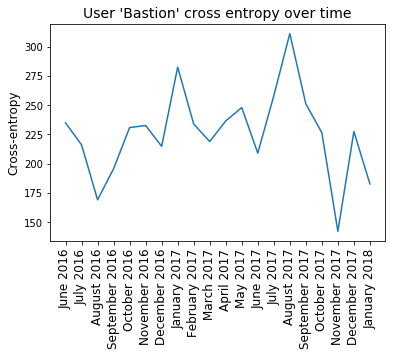

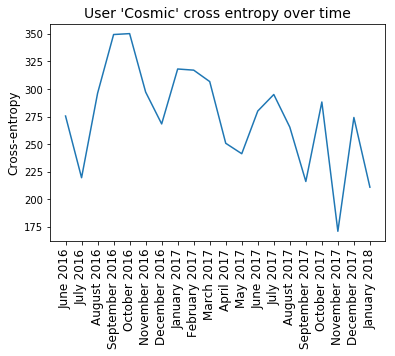

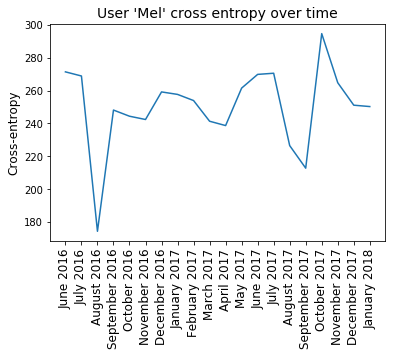

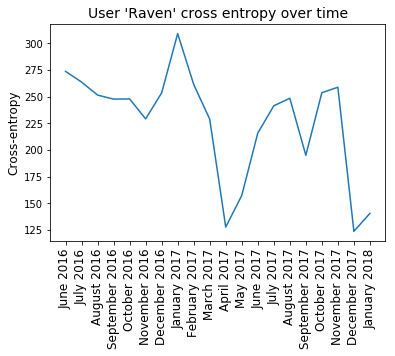

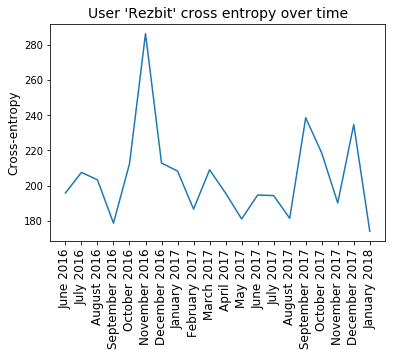

In [70]:
for user in active_user_list:
    cross_entropy = utils.score_user(user, df_no_train, trigram_counts, trigram_context_totals)
    utils.plot_entropy(user, cross_entropy, month_labels)

I want to add error bars to the points on these plots so we can better understand how seriously to take these results (basically how many posts the user had each month).

Ideally we'd like to see the cross-entropy of the user decrease over time. Or see it decrease, stabalize at some low value, and then start to rise back up. Either trend would suggest that the user is adopting more of the language of the forum as time goes on (evidence in support of the original work by Danescu et al. 2013). Because these are users that have remained active throught the lifespan of the forum we cannot visualize their full user life cycle (i.e. entry to forum -> linguistic maturity -> user churn).

#### !! UNDER CONSTRUCTION !!

#### c) find users that were initially very active and dropped off toward the end of 2016 or early 2017

If we define a time frame of inactivity to declare a user has churned, we can look for candidate users that may display a full life cycle.

In [73]:
# INCOMPLETE!!

# code to find users here
candidate_users = []

#### d) analyze these users to see if they display a full life cycle

In [ ]:
for user in candidate_users:
    cross_entropy = utils.score_user(user, df_no_train, trigram_counts, trigram_context_totals)
    utils.plot_entropy(user, cross_entropy, month_labels)

***

## !! UNDER CONSTRUCTION!!

## Don't go past this point! Dead end!

<div align=right>
    [back to top](#toc)
</div>

<a id="section6"></a>

### Step 6) Creating a classifier for user churn prediction

In [196]:
# where to start...

***

### That's the end!... what more were you hoping to find down here! :(